In [1]:
import pandas as pd

Primer obtindrem la població per sexe i edat a cada barri i any

In [3]:
#Carreguem arxiu amb població per barri i any
poblacio = pd.read_csv('../Data_cleaning/selectedVars/pad_mdba_sexe_edat-1.csv')
poblacio.head()

,Codi_Barri,Nom_Barri,Data_Referencia,SEXE,EDAT_1,Valor
0,1,el Raval,2024-01-01T00:00:00,1,0,11
1,1,el Raval,2024-01-01T00:00:00,1,1,11
2,1,el Raval,2024-01-01T00:00:00,1,2,11
3,1,el Raval,2024-01-01T00:00:00,1,3,15
4,1,el Raval,2024-01-01T00:00:00,1,4,8


In [4]:
#Afegim l'any a partir de la columna 'Data_Referencia'
poblacio['Any'] = pd.to_datetime(poblacio['Data_Referencia']).dt.year
poblacio.head()

,Codi_Barri,Nom_Barri,Data_Referencia,SEXE,EDAT_1,Valor,Any
0,1,el Raval,2024-01-01T00:00:00,1,0,11,2024
1,1,el Raval,2024-01-01T00:00:00,1,1,11,2024
2,1,el Raval,2024-01-01T00:00:00,1,2,11,2024
3,1,el Raval,2024-01-01T00:00:00,1,3,15,2024
4,1,el Raval,2024-01-01T00:00:00,1,4,8,2024


La variable edat està codificada, així que necessitem els valors. Les obtenim del dataset que conté totes les dimensions utilitzades als datasets relacionats amb el padró.

In [6]:
#Carreguem el dataset amb els codis i valors de les dimensions
dimensions = pd.read_csv("../Data_cleaning/selectedVars/pad-dimensions.csv")
#Separem la dimnesió EDAT_1
dim_edat_1 = dimensions[dimensions['Desc_Dimensio']=='EDAT_1']
print(dim_edat_1)

     Codi_Dimensio Desc_Dimensio  Codi_Valor Desc_Valor_CA  Desc_Valor_EN
2                2        EDAT_1           0        0 anys        0 years
3                2        EDAT_1           1        1 anys        1 years
4                2        EDAT_1           2        2 anys        2 years
5                2        EDAT_1           3        3 anys        3 years
6                2        EDAT_1           4        4 anys        4 years
..             ...           ...         ...           ...            ...
99               2        EDAT_1          97       97 anys       97 years
100              2        EDAT_1          98       98 anys       98 years
101              2        EDAT_1          99       99 anys       99 years
102              2        EDAT_1         100     ≥100 anys     ≥100 years
103              2        EDAT_1         101     No consta  Not available

[102 rows x 5 columns]


L'objectiu d'aquest notebook és generar un dataset amb totes les variables necessàries de les diferents fonts de dades agregades. El creem partint dels codis dels barris i anys únics.

In [8]:
#Creem el dataset on anirem afegint les variables
agregated_df = poblacio[['Codi_Barri', 'Any']].drop_duplicates()
print(agregated_df['Codi_Barri'].unique())
print(agregated_df['Any'].unique())

[ 1 10 19  2  3  5  4  6  7  8  9 11 15 18 12 13 14 16 17 20 21 22 29 23
 24 25 28 26 27 30 31 32 33 45 34 35 36 37 38 40 39 41 43 42 44 46 47 48
 49 50 51 52 53 56 54 55 57 60 58 59 61 62 63 64 65 66 68 67 69 70 71 72
 73]
[2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011
 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997]


A continuació afegirem la superfície per cada barri i any. Pels anys que no existeixen, afegirem el valor null

In [10]:
#Carreguem el dataset amb la superfície per barris i anys i afegim el valor al dataset agregated_df
sup = pd.read_csv("../Data_cleaning/selectedVars/est-superficie.csv")
agregated_df = pd.merge(agregated_df, sup, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha)
0,1,1997,NaN,NaN
1,1,1998,NaN,NaN
2,1,1999,NaN,NaN
3,1,2000,NaN,NaN
4,1,2001,NaN,NaN
...,...,...,...,...
2027,73,2019,la Verneda i la Pau,112.7
2028,73,2020,la Verneda i la Pau,113.0
2029,73,2021,la Verneda i la Pau,113.0
2030,73,2023,NaN,NaN


In [11]:
#Calculem les variables Poblacio_total i Poblacio_20_40 per cada barri i any. 
#Però primer hem de substituir els valors '..' per 0
poblacio['Valor'] = pd.to_numeric(poblacio['Valor'], errors='coerce')
poblacio['Valor'] = poblacio['Valor'].fillna(0)
poblacio['Valor'] = poblacio['Valor'].astype(int)

#Agrupem els valors
pob_grouped = poblacio.groupby(['Codi_Barri', 'Any', 'EDAT_1'])['Valor'].sum().reset_index()
pob_20_40 = pob_grouped[(pob_grouped['EDAT_1'].between(20,39))]
pob_20_40 = pob_20_40.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
Poblacio_total = poblacio.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
Poblacio_20_40 = pob_20_40.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()

#Reanomenem les columnes 'Valor'
Poblacio_total = Poblacio_total.rename(columns={'Valor': 'Poblacio_total'})
Poblacio_20_40 = Poblacio_20_40.rename(columns={'Valor': 'Poblacio_20_40'})

#Ajuntem els datasets
poblacio = pd.merge(Poblacio_total, Poblacio_20_40, on = ['Codi_Barri', 'Any'])

#Agreguem els valors a l'agregate_df
agregated_df = pd.merge(agregated_df, poblacio, on = ['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40
0,1,1997,NaN,NaN,33798.0,9317.0
1,1,1998,NaN,NaN,34831.0,9901.0
2,1,1999,NaN,NaN,35064.0,10217.0
3,1,2000,NaN,NaN,35026.0,10490.0
4,1,2001,NaN,NaN,37305.0,12327.0
...,...,...,...,...,...,...
2027,73,2019,la Verneda i la Pau,112.7,NaN,NaN
2028,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0
2029,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0
2030,73,2023,NaN,NaN,29173.0,6717.0


Del dataset "Població de més de 16 anys per titulació acadèmica", volem calcular tres variables: Pob_sense_estudis, Pob_amb_estudis_universitaris, i Pob_20_40_amb_estudis_universitaris.

In [13]:
#Primer carreguem el dataset corresponent
estudis = pd.read_csv('../Data_cleaning/selectedVars/pad_mdb_niv-educa-esta_edat-q_sexe.csv')
estudis.head()

,Codi_Barri,Nom_Barri,Data_Referencia,SEXE,EDAT_Q,NIV_EDUCA_esta,Valor
0,1,el Raval,2024-01-01T00:00:00,2,4,1,..
1,1,el Raval,2024-01-01T00:00:00,1,5,1,..
2,1,el Raval,2024-01-01T00:00:00,2,5,1,6
3,1,el Raval,2024-01-01T00:00:00,1,6,1,..
4,1,el Raval,2024-01-01T00:00:00,2,6,1,6


In [14]:
#Afegim l'any a partir de la columna 'Data_Referencia'
estudis['Any'] = pd.to_datetime(estudis['Data_Referencia']).dt.year
#Separem les dimensions EDAT_Q i NIV_EDUCA_esta
dim_educa = dimensions[dimensions['Desc_Dimensio']=='NIV_EDUCA_esta']
dim_edat_q = dimensions[dimensions['Desc_Dimensio']=='EDAT_Q']
print(dim_educa)
print(dim_edat_q)

     Codi_Dimensio   Desc_Dimensio  Codi_Valor  \
203              9  NIV_EDUCA_esta           1   
204              9  NIV_EDUCA_esta           2   
205              9  NIV_EDUCA_esta           3   
206              9  NIV_EDUCA_esta           4   
207              9  NIV_EDUCA_esta           5   
208              9  NIV_EDUCA_esta           6   

                                         Desc_Valor_CA  \
203                                      Sense estudis   
204    Estudis primaris, certificat d'escolaritat, EGB   
205   Batxillerat elemental, graduat escolar, ESO, FPI   
206  Batxillerat superior, BUP, COU, FPII, CFGM gra...   
207          Estudis universitaris, CFGS grau superior   
208                                          No consta   

                                         Desc_Valor_EN  
203                        Less than primary education  
204                                  Primary education  
205                          Lower secondary education  
206  Upper sec

In [15]:
#Calculem les variables Poblacio_sense_estudis, Poblacio_univ, Poblacio_20_40_univ per cada barri i any. 
#Però primer hem de substituir els valors '..' per 0
estudis['Valor'] = pd.to_numeric(estudis['Valor'], errors='coerce')
estudis['Valor'] = estudis['Valor'].fillna(0)
estudis['Valor'] = estudis['Valor'].astype(int)

#Agrupem els valors
estudis_grouped = estudis.groupby(['Codi_Barri', 'Any', 'EDAT_Q', 'NIV_EDUCA_esta'])['Valor'].sum().reset_index()
estudis_20_40 = estudis_grouped[(estudis_grouped['EDAT_Q'].between(4,7))]
estudis_20_40 = estudis_20_40.groupby(['Codi_Barri', 'Any', 'NIV_EDUCA_esta'])['Valor'].sum().reset_index()

Poblacio_sense_estudis = estudis[(estudis['NIV_EDUCA_esta']==1)].groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
Poblacio_univ = estudis[(estudis['NIV_EDUCA_esta']==5)].groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
Poblacio_20_40_univ = estudis_20_40[(estudis_20_40['NIV_EDUCA_esta']==5)].groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()

#Reanomenem les columnes 'Valor'
Poblacio_sense_estudis = Poblacio_sense_estudis.rename(columns={'Valor': 'Poblacio_sense_estudis'})
Poblacio_univ = Poblacio_univ.rename(columns={'Valor': 'Poblacio_univ'})
Poblacio_20_40_univ = Poblacio_20_40_univ.rename(columns={'Valor': 'Poblacio_20_40_univ'})

#Ajuntem els datasets
estudis = pd.merge(Poblacio_sense_estudis, Poblacio_univ, on = ['Codi_Barri', 'Any'])
estudis = pd.merge(estudis, Poblacio_20_40_univ, on = ['Codi_Barri', 'Any'])

#Agreguem els valors a l'agregate_df
agregated_df = pd.merge(agregated_df, estudis, on = ['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771
...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916


Ara introduirem la renda per càpita dels barris i l'índex de Gini que indica la desigualtat en els ingressos de la població. Aquesta informació la tenim als datasets "Renda tributària neta mitjana per persona" i "Índex de Gini de la renda tributària a Barcelona"

In [17]:
#Primer carreguem els datasets corresponents
renda = pd.read_csv('../Data_cleaning/selectedVars/renda-tributaria-per-persona-atlas-distribucio.csv')
gini = pd.read_csv('../Data_cleaning/selectedVars/atles-renda-index-gini.csv')
print(renda.head())
print(gini.head())

   Codi_Barri Nom_Barri   Any  Import_Euros
0           1  el Raval  2022         12551
1           1  el Raval  2022         10715
2           1  el Raval  2022          9937
3           1  el Raval  2022         12214
4           1  el Raval  2022         10296
   Codi_Barri Nom_Barri   Any Index_Gini
0           1  el Raval  2022       35.6
1           1  el Raval  2022       34.8
2           1  el Raval  2022       36.1
3           1  el Raval  2022       35.6
4           1  el Raval  2022       35.7


Observem diversos valors per any i barri, i això és així perquè hi ha diverses seccions censals a cada barri. Calcularem la mitjana per cada barri i any.

In [19]:
#Calculem les mitjanes renda_mitjana i Gini per cada barri i any. 
#Però primer hem de substituir els valors nuls per 0
renda['Import_Euros'] = pd.to_numeric(renda['Import_Euros'], errors='coerce')
gini['Index_Gini'] = pd.to_numeric(gini['Index_Gini'], errors='coerce')
renda['Import_Euros'] = renda['Import_Euros'].fillna(0)
gini['Index_Gini'] = gini['Index_Gini'].fillna(0)
renda['Import_Euros'] = renda['Import_Euros'].astype(float)
gini['Index_Gini'] = gini['Index_Gini'].astype(float)

#Calculem les mitjanes
renda_mitjana = renda.groupby(['Codi_Barri', 'Any'])['Import_Euros'].mean().reset_index()
gini_mig = gini.groupby(['Codi_Barri', 'Any'])['Index_Gini'].mean().reset_index()

#Reanomenem les columnes
renda_mitjana = renda_mitjana.rename(columns={'Import_Euros': 'renda_mitjana'})
gini_mig = gini_mig.rename(columns={'Index_Gini': 'renda_Gini'})

#Ajuntem els 2 datasets
rendes = pd.merge(renda_mitjana, gini_mig, on = ['Codi_Barri', 'Any'], how='outer')

#Agreguem els valors a l'agregate_df
agregated_df = pd.merge(agregated_df, rendes, on = ['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,renda_Gini
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157,NaN,NaN
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240,NaN,NaN
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299,NaN,NaN
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461,NaN,NaN
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675,13302.523810,27.785714
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652,13869.285714,27.128571
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709,14411.047619,27.271429
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916,NaN,NaN


Ara hem d'extreure les variables relacionades amb l'immigració. Amb els datasets "Canvis de domicili per sexe i barri de baixa i alta" calcularem el nombre de persones que arriben des de barris amb més renda, i els que marxen a barris amb menys renda; del "Població emigrants per continents de destinació" calcularem els que marxen del barri a continents amb menys renda, i del "Població per continent, país de naixement, ..." el nombre d'habitants del barri nascuts a paisos amb menys o més IDH.

In [21]:
#Primer carreguem els quatre datasets
em_barris = pd.read_csv('../Data_cleaning/selectedVars/pad_cdo_b_sexe_barri-des.csv')
em_continent = pd.read_csv('../Data_cleaning/selectedVars/pad_emi_mdbas_sexe_edat-q_continent-m.csv')
pob_IDH = pd.read_csv('../Data_cleaning/selectedVars/pad_mdbas_lloc-naix-pais_lloc-naix-continent_sexe.csv')
IDH = pd.read_csv('../Data_cleaning/selectedVars/hdr-data.csv')
print(em_barris.head())
print(em_continent.head())
print(pob_IDH.head())
print(IDH.head())

   Codi_Barri Nom_Barri  CODI_BARRI_DEST   Any  SEXE Valor
0           1  el Raval                1  2023     1   688
1           1  el Raval                1  2023     2   806
2           1  el Raval                2  2023     1   204
3           1  el Raval                2  2023     2   461
4           1  el Raval                3  2023     1    30
   Codi_Barri Nom_Barri  CONTINENT_MOV   Any  SEXE Valor
0           1  el Raval              3  2023     1    ..
1           1  el Raval              3  2023     2    ..
2           1  el Raval              4  2023     1    ..
3           1  el Raval              4  2023     2    ..
4           1  el Raval              4  2023     2    ..
   Codi_Barri Nom_Barri  LLOC_NAIX_PAIS      Data_Referencia  SEXE Valor
0           1  el Raval               3  2024-01-01T00:00:00     1    ..
1           1  el Raval              15  2024-01-01T00:00:00     1    ..
2           1  el Raval              15  2024-01-01T00:00:00     2    ..
3           

In [22]:
#Comencem afegint la renda mitjana dels barris d'origen i destí
columns = ['Codi_Barri', 'Any', 'renda_mitjana']
rendes_barris = agregated_df[columns]
em_barris = pd.merge(em_barris, rendes_barris, on=['Codi_Barri', 'Any'])
em_barris = em_barris.rename(columns={'Codi_Barri': 'Barri_origen', 'renda_mitjana': 'renda_origen', 'CODI_BARRI_DEST': 'Codi_Barri'})
em_barris = pd.merge(em_barris, rendes_barris, on=['Codi_Barri', 'Any'])
em_barris = em_barris.rename(columns={'renda_mitjana': 'renda_destí'})
em_barris.head()

,Barri_origen,Nom_Barri,Codi_Barri,Any,SEXE,Valor,renda_origen,renda_destí
0,1,el Raval,1,2023,1,688,NaN,NaN
1,1,el Raval,1,2023,2,806,NaN,NaN
2,1,el Raval,2,2023,1,204,NaN,NaN
3,1,el Raval,2,2023,2,461,NaN,NaN
4,1,el Raval,3,2023,1,30,NaN,NaN


In [23]:
#Creem la nova variable que ens indica si la renda al destí és més baixa, és a dir, si el barri des d'on es desplaça l'immigrant és de classe més alta
em_barris['gent_intra'] = 'NO'
em_barris.loc[em_barris['renda_origen'] > em_barris['renda_destí'], 'gent_intra'] = 'SI'

In [24]:
#Ara calcularem per cada Codi_Barri (destí), total persones que arriben, i total persones que arriben des de barris amb més renda (gent_intra==SI)
em_barris['Valor'] = pd.to_numeric(em_barris['Valor'], errors='coerce')
em_barris['Valor'] = em_barris['Valor'].fillna(0)
em_barris['Valor'] = em_barris['Valor'].astype(int)

#Separem els que marxen del barri
surt_barris = em_barris.groupby(['Barri_origen', 'Any'])['Valor'].sum().reset_index()
surt_barris = surt_barris.rename(columns = {'Barri_origen': 'Codi_Barri'})

#Calculem les variables
total_arribats_intra = em_barris.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
total_arribats_gentrif = em_barris[(em_barris['gent_intra']=='SI')].groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
total_marxen_BCN = surt_barris.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()

#Reanomenem les variables
total_arribats_intra = total_arribats_intra.rename(columns = {'Valor': 'Total_arribats_BCN'})
total_arribats_gentrif = total_arribats_gentrif.rename(columns = {'Valor': 'Total_arribats_BCN_inc_renda'})
total_marxen_BCN = total_marxen_BCN.rename(columns = {'Valor': 'Total_marxen_barri_BCN'})

#Agrupem els valors i afegim al dataset agregated_df
em_barris = pd.merge(total_arribats_intra, total_arribats_gentrif, on=['Codi_Barri', 'Any'])
em_barris = pd.merge(em_barris, total_marxen_BCN, on=['Codi_Barri', 'Any'])
agregated_df = pd.merge(agregated_df, em_barris, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,renda_Gini,Total_arribats_BCN,Total_arribats_BCN_inc_renda,Total_marxen_barri_BCN
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157,NaN,NaN,NaN,NaN,NaN
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240,NaN,NaN,NaN,NaN,NaN
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299,NaN,NaN,NaN,NaN,NaN
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461,NaN,NaN,NaN,NaN,NaN
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675,13302.523810,27.785714,974.0,485.0,819.0
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652,13869.285714,27.128571,1351.0,664.0,1117.0
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709,14411.047619,27.271429,1363.0,688.0,1045.0
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916,NaN,NaN,NaN,NaN,NaN


In [25]:
#Creem la dimensio continents
continent = dimensions[dimensions['Desc_Dimensio']=='CONTINENT_MOV']
continent

,Codi_Dimensio,Desc_Dimensio,Codi_Valor,Desc_Valor_CA,Desc_Valor_EN
757,23,CONTINENT_MOV,1,Àfrica,Africa
758,23,CONTINENT_MOV,2,Amèrica,Americas
759,23,CONTINENT_MOV,3,Àsia,Asia
760,23,CONTINENT_MOV,4,Europa,Europe
761,23,CONTINENT_MOV,5,Oceania,Oceania
762,23,CONTINENT_MOV,999,No consta,Not available


In [26]:
#Comptabilitzarem del dataset em_continent les persones que marxen de cada barri a altres continents i a un continent on probablement l'IDH sigui menor. 
#Aquesta serà la variable Total_marxen_BCN, Total_expulsats, i comptabilitzarem aquells de cada barri que marxen amb destinació Àfrica o Àsia.
em_continent['Valor'] = pd.to_numeric(em_continent['Valor'], errors='coerce')
em_continent['Valor'] = em_continent['Valor'].fillna(0)
em_continent['Valor'] = em_continent['Valor'].astype(int)
em_continent_less_IDH = em_continent[(em_continent['CONTINENT_MOV']==1) | (em_continent['CONTINENT_MOV']==3)]

total_marxen_BCN = em_continent.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
total_expulsats = em_continent_less_IDH.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()

#Reanomenem variables
total_marxen_BCN = total_marxen_BCN.rename(columns = {'Valor': 'Total_marxen_fora_BCN'})
total_expulsats = total_expulsats.rename(columns = {'Valor': 'Total_expulsats'})

#Agrupem els valors i afegim al dataset agregated_df
em_continent = pd.merge(total_marxen_BCN, total_expulsats, on=['Codi_Barri', 'Any'])
agregated_df = pd.merge(agregated_df, em_continent, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,renda_Gini,Total_arribats_BCN,Total_arribats_BCN_inc_renda,Total_marxen_barri_BCN,Total_marxen_fora_BCN,Total_expulsats
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157,NaN,NaN,NaN,NaN,NaN,121.0,0.0
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240,NaN,NaN,NaN,NaN,NaN,196.0,0.0
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299,NaN,NaN,NaN,NaN,NaN,254.0,0.0
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461,NaN,NaN,NaN,NaN,NaN,404.0,0.0
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771,NaN,NaN,NaN,NaN,NaN,844.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675,13302.523810,27.785714,974.0,485.0,819.0,100.0,0.0
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652,13869.285714,27.128571,1351.0,664.0,1117.0,158.0,0.0
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709,14411.047619,27.271429,1363.0,688.0,1045.0,188.0,0.0
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916,NaN,NaN,NaN,NaN,NaN,221.0,0.0


Finalment, per saber la població que prové de països amb més o menys IDH, primer analitzarem el dataset corresponent a l'IDH dels països.

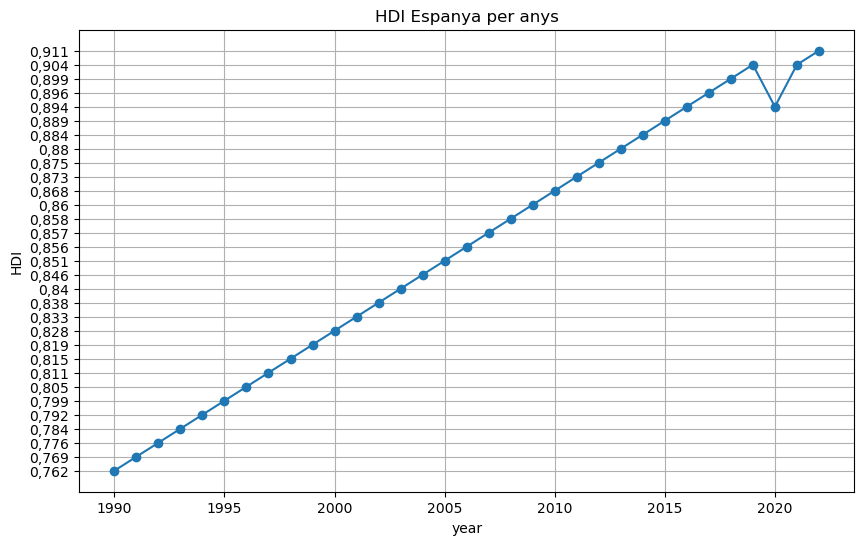

In [28]:
import matplotlib.pyplot as plt

#Mostrem l'IDH d'Espanya per anys
spain_idh = IDH[IDH['country'] == 'Spain']
plt.figure(figsize=(10, 6))
plt.plot(spain_idh['year'], spain_idh['value'], marker='o')
plt.xlabel('year')
plt.ylabel('HDI')
plt.title('HDI Espanya per anys')
plt.grid(True)
plt.show()

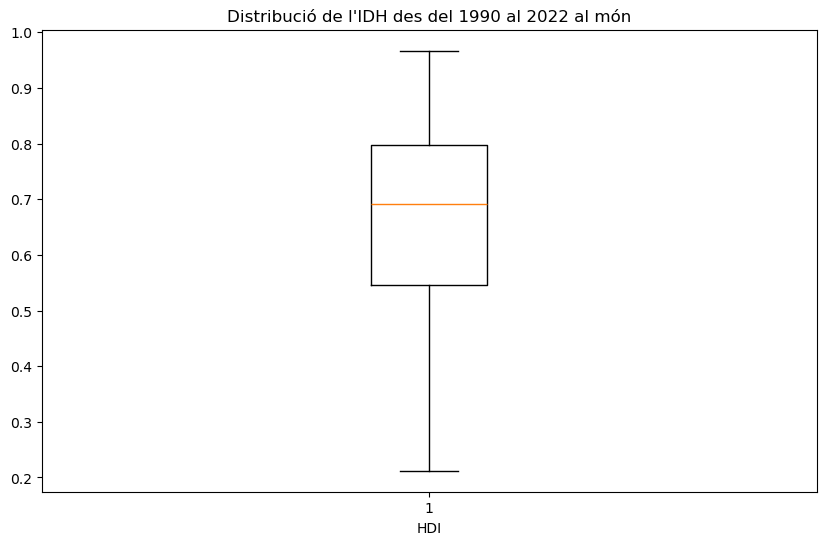

In [29]:
#Tenim que l'IDH d'Espanya es troba entre els 0,762 l'any 1990 i 0,911 l'any 2022. No volem tots els països que estiguin per sobre o sota d'aquests valors,
#sino només aquells que ho estiguin considerablement. Per a això, primer farem un boxplot de tot el conjunt per veure la distribució dels valors.
plt.figure(figsize=(10, 6))
plt.boxplot(pd.to_numeric(IDH['value'].str.replace(',','.')), vert=True)
plt.xlabel('HDI')
plt.title("Distribució de l'IDH des del 1990 al 2022 al món")
plt.show()

Observem que el 50% dels valors es troben per sobre de 0,7; a més que un 25% es troben entre 0,55 aproximadament i 0,7; Espanya tenia IDH entre 0,762 i 0,911. Per tant, es considera tenir en compte els països que estiguin com a mínim un 5% per sobre, ja que els IDH d'Espanya són bastant elevats, i un 10% per sota. Tot i què per calcular aquests percentatges no s'ha tingut en compte els anys, per assignar els països al dataset "Població per continent, país de naixement, ..." es calcularà tenint en compte la data.


In [31]:
#Primer creem la dimensió països
paisos = dimensions[dimensions['Desc_Dimensio']=='LLOC_NAIX_PAIS']

#Assignem a cada païs del dataset IDH el codi corresponent de les dimensions paisos que es fa servir al padró. Per això fem servir la descripció en anglès.
IDH = pd.merge(IDH, paisos[['Desc_Valor_EN', 'Codi_Valor']], left_on='country', right_on='Desc_Valor_EN')

#Comprovem que no queden països sense codi assignat
print(IDH['Desc_Valor_EN'].isnull().sum())

0


In [32]:
#Definim una funció per assignar una columna amb el valor 1 si l'IDH aquell any supera un 5% al d'Espanya, -1 si és un 10% inferior, i 0 en els altres casos.
def categorize_idh(row):
    spain_value_per_year = spain_idh[spain_idh['year'] == row['year']]['value'].iloc[0] if not spain_idh[spain_idh['year'] == row['year']]['value'].empty else 0

    if row['value'] > 1.05 * spain_value_per_year:
      return 1
    elif row['value'] < 0.90 * spain_value_per_year:
      return -1
    else:
      return 0

#Hem de substituir el separador decimal dels valors per '.'
spain_idh['value'] = pd.to_numeric(spain_idh['value'].str.replace(',','.'))
IDH['value'] = pd.to_numeric(IDH['value'].str.replace(',','.'))

#Apliquem la funció per crear la nova columna
IDH['idh_category'] = IDH.apply(categorize_idh, axis=1)

In [33]:
#Busquem el codi d'Espanya
paisos[paisos['Desc_Valor_EN']=="Spain"]

,Codi_Dimensio,Desc_Dimensio,Codi_Valor,Desc_Valor_CA,Desc_Valor_EN
277,11,LLOC_NAIX_PAIS,58,Espanya,Spain


In [34]:
#Comptabilitzarem del dataset pob_IDH les persones que viuen de cada barri de països amb IDH considerablement superior o inferior. 
#Aquesta serà la variable poblacio_IDH_sup i poblacio_IDH_inf

#Primer afegim l'any a partir de la columna 'Data_Referencia'
pob_IDH['Any'] = pd.to_datetime(pob_IDH['Data_Referencia']).dt.year

#Canviem el valor a numèric i eliminem nuls
pob_IDH['Valor'] = pd.to_numeric(pob_IDH['Valor'], errors='coerce')
pob_IDH['Valor'] = pob_IDH['Valor'].fillna(0)
pob_IDH['Valor'] = pob_IDH['Valor'].astype(int)

#Agreguem la columna 'idh_category' del dataset 'IDH', però hem de canviar de nom la columna 'year' i 'Codi_Valor' per que coincideixin
IDH = IDH.rename(columns = {'year': 'Any', 'Codi_Valor': 'LLOC_NAIX_PAIS'})
pob_IDH = pd.merge(pob_IDH, IDH[['LLOC_NAIX_PAIS', 'Any', 'idh_category']], on=['LLOC_NAIX_PAIS', 'Any'])

#Creem les variables
poblacio_immigrant = (pob_IDH[(pob_IDH['LLOC_NAIX_PAIS']==58)]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
poblacio_IDH_sup = (pob_IDH[(pob_IDH['idh_category']==1)]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
poblacio_IDH_inf = (pob_IDH[(pob_IDH['idh_category']==-1)]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()

#Reanomenem variables
poblacio_immigrant = poblacio_immigrant.rename(columns = {'Valor': 'poblacio_immigrant'})
poblacio_IDH_sup = poblacio_IDH_sup.rename(columns = {'Valor': 'poblacio_IDH_sup'})
poblacio_IDH_inf = poblacio_IDH_inf.rename(columns = {'Valor': 'poblacio_IDH_inf'})

#Agrupem els valors i afegim al dataset agregated_df
pob_IDH = pd.merge(poblacio_immigrant, poblacio_IDH_sup, on=['Codi_Barri', 'Any'])
pob_IDH = pd.merge(pob_IDH, poblacio_IDH_inf, on=['Codi_Barri', 'Any'])
agregated_df = pd.merge(agregated_df, pob_IDH, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,renda_Gini,Total_arribats_BCN,Total_arribats_BCN_inc_renda,Total_marxen_barri_BCN,Total_marxen_fora_BCN,Total_expulsats,poblacio_immigrant,poblacio_IDH_sup,poblacio_IDH_inf
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157,NaN,NaN,NaN,NaN,NaN,121.0,0.0,30186.0,5.0,2497.0
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240,NaN,NaN,NaN,NaN,NaN,196.0,0.0,30367.0,10.0,3179.0
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299,NaN,NaN,NaN,NaN,NaN,254.0,0.0,29716.0,16.0,3891.0
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461,NaN,NaN,NaN,NaN,NaN,404.0,0.0,28811.0,21.0,4567.0
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771,NaN,NaN,NaN,NaN,NaN,844.0,0.0,28020.0,51.0,7238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675,13302.523810,27.785714,974.0,485.0,819.0,100.0,0.0,NaN,NaN,NaN
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652,13869.285714,27.128571,1351.0,664.0,1117.0,158.0,0.0,NaN,NaN,NaN
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709,14411.047619,27.271429,1363.0,688.0,1045.0,188.0,0.0,NaN,NaN,NaN
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916,NaN,NaN,NaN,NaN,NaN,221.0,0.0,NaN,NaN,NaN


A continuació extreurem la variable persones empadronades soles del dataset "Població empadronada sola per domicili, sexe i edat", per homes i dones.

In [36]:
#Primer carreguem el dataset
pad_soles = pd.read_csv('../Data_cleaning/selectedVars/pad_sol_mdb_sexe_edat-q.csv')
pad_soles.head()

,Codi_Barri,Nom_Barri,Data_Referencia,SEXE,EDAT_Q,Valor
0,1,el Raval,2024-01-01T00:00:00,1,4,..
1,1,el Raval,2024-01-01T00:00:00,1,5,14
2,1,el Raval,2024-01-01T00:00:00,1,6,6
3,1,el Raval,2024-01-01T00:00:00,1,7,9
4,1,el Raval,2024-01-01T00:00:00,1,8,..


In [37]:
#Afegim l'any a partir de la columna 'Data_Referencia'
pad_soles['Any'] = pd.to_datetime(pad_soles['Data_Referencia']).dt.year

#Canviem el valor a numèric i eliminem nuls
pad_soles['Valor'] = pd.to_numeric(pad_soles['Valor'], errors='coerce')
pad_soles['Valor'] = pad_soles['Valor'].fillna(0)
pad_soles['Valor'] = pad_soles['Valor'].astype(int)

#Creem les variables
total_sols = pad_soles.groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()

#Reanomenem variables
total_sols = total_sols.rename(columns = {'Valor': 'total_viuen_sols'})

#Agrupem els valors i afegim al dataset agregated_df
agregated_df = pd.merge(agregated_df, total_sols, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,renda_Gini,Total_arribats_BCN,Total_arribats_BCN_inc_renda,Total_marxen_barri_BCN,Total_marxen_fora_BCN,Total_expulsats,poblacio_immigrant,poblacio_IDH_sup,poblacio_IDH_inf,total_viuen_sols
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157,NaN,NaN,NaN,NaN,NaN,121.0,0.0,30186.0,5.0,2497.0,4750
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240,NaN,NaN,NaN,NaN,NaN,196.0,0.0,30367.0,10.0,3179.0,5077
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299,NaN,NaN,NaN,NaN,NaN,254.0,0.0,29716.0,16.0,3891.0,5181
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461,NaN,NaN,NaN,NaN,NaN,404.0,0.0,28811.0,21.0,4567.0,5280
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771,NaN,NaN,NaN,NaN,NaN,844.0,0.0,28020.0,51.0,7238.0,5328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675,13302.523810,27.785714,974.0,485.0,819.0,100.0,0.0,NaN,NaN,NaN,2263
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652,13869.285714,27.128571,1351.0,664.0,1117.0,158.0,0.0,NaN,NaN,NaN,2325
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709,14411.047619,27.271429,1363.0,688.0,1045.0,188.0,0.0,NaN,NaN,NaN,2362
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916,NaN,NaN,NaN,NaN,NaN,221.0,0.0,NaN,NaN,NaN,2425


Ara treballarem el nombre de contractes de lloguer i el preu mig.

In [39]:
#Primer carreguem els datasets
lloguers = pd.read_csv('../Data_cleaning/selectedVars/anual_bcn_contractes.csv', quotechar='"')
preu_lloguer = pd.read_csv('../Data_cleaning/selectedVars/anual_bcn_lloguer_m2.csv', quotechar='"')
lloguers.head()

,Codi_barri,Nom_barri,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
0,1,el Raval,1.207,1.626,2.003,1.467,1.929,1.918,2.003,1.733,1.484,1.583,1.522
1,2,el Barri Gòtic,614.000,882.000,1.050,730.000,890.000,967.000,808.000,785.000,684.000,630.000,611.000
2,3,la Barceloneta,236.000,341.000,362.000,274.000,385.000,415.000,857.000,789.000,703.000,566.000,533.000
3,4,"Sant Pere, Santa Caterina i la Ribera",857.000,1.109,1.356,991.000,1.340,1.307,1.309,1.177,1.014,982.000,869.000
4,5,el Fort Pienc,770.000,1.033,1.398,914.000,1.144,1.191,1.054,870.000,806.000,910.000,862.000


In [40]:
#Hem de convertir les columnes corresponents als anys per tal que cada filera contingui el valor del preu/contractes de lloguer de l'any corresponent
lloguers = pd.melt(lloguers, id_vars=['Codi_barri', 'Nom_barri'], var_name='Any', value_name='Contractes')
lloguers['Any'] = pd.to_numeric(lloguers['Any'], errors='coerce')
lloguers.dropna(subset=['Any'], inplace=True)
lloguers['Any'] = lloguers['Any'].astype(int)
preu_lloguer = pd.melt(preu_lloguer, id_vars=['Codi_barri', 'Nom_barri'], var_name='Any', value_name='Preu_lloguer')
preu_lloguer['Any'] = pd.to_numeric(preu_lloguer['Any'], errors='coerce')
preu_lloguer.dropna(subset=['Any'], inplace=True)
preu_lloguer['Any'] = preu_lloguer['Any'].astype(int)
preu_lloguer['Preu_lloguer'] = pd.to_numeric(preu_lloguer['Preu_lloguer'], errors='coerce')
print(lloguers.head())
print(preu_lloguer.head())

   Codi_barri                                Nom_barri   Any  Contractes
0           1                               el Raval    2023       1.207
1           2                         el Barri Gòtic    2023     614.000
2           3                         la Barceloneta    2023     236.000
3           4  Sant Pere, Santa Caterina i la Ribera    2023     857.000
4           5                          el Fort Pienc    2023     770.000
   Codi_barri                                Nom_barri   Any  Preu_lloguer
0           1                               el Raval    2023         15.89
1           2                         el Barri Gòtic    2023         16.44
2           3                         la Barceloneta    2023         18.98
3           4  Sant Pere, Santa Caterina i la Ribera    2023         17.41
4           5                          el Fort Pienc    2023         16.08


In [41]:
#Creem les variables
contractes = lloguers.groupby(['Codi_barri', 'Any'])['Contractes'].sum().reset_index()
preu_lloguer = preu_lloguer.groupby(['Codi_barri', 'Any'])['Preu_lloguer'].sum().reset_index()

#Reanomenem columnes
preu_lloguer = preu_lloguer.rename(columns = {'Preu': 'Preu_lloguer', 'Codi_barri': 'Codi_Barri'})
contractes = contractes.rename(columns = {'Codi_barri': 'Codi_Barri'})

#Agrupem els valors i afegim al dataset agregated_df
lloguers = pd.merge(contractes, preu_lloguer, on=['Codi_Barri', 'Any'])
agregated_df = pd.merge(agregated_df, lloguers, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Total_arribats_BCN_inc_renda,Total_marxen_barri_BCN,Total_marxen_fora_BCN,Total_expulsats,poblacio_immigrant,poblacio_IDH_sup,poblacio_IDH_inf,total_viuen_sols,Contractes,Preu_lloguer
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157,NaN,...,NaN,NaN,121.0,0.0,30186.0,5.0,2497.0,4750,NaN,NaN
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240,NaN,...,NaN,NaN,196.0,0.0,30367.0,10.0,3179.0,5077,NaN,NaN
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299,NaN,...,NaN,NaN,254.0,0.0,29716.0,16.0,3891.0,5181,NaN,NaN
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461,NaN,...,NaN,NaN,404.0,0.0,28811.0,21.0,4567.0,5280,NaN,NaN
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771,NaN,...,NaN,NaN,844.0,0.0,28020.0,51.0,7238.0,5328,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675,13302.523810,...,485.0,819.0,100.0,0.0,NaN,NaN,NaN,2263,330.0,11.55
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652,13869.285714,...,664.0,1117.0,158.0,0.0,NaN,NaN,NaN,2325,379.0,11.07
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709,14411.047619,...,688.0,1045.0,188.0,0.0,NaN,NaN,NaN,2362,576.0,11.42
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916,NaN,...,NaN,NaN,221.0,0.0,NaN,NaN,NaN,2425,658.0,16.30


Afegirem l'edat mitjana de les edificacions per barris a partir del dataset corresponent.

In [43]:
#Primer carreguem els datasets
edat_edif = pd.read_csv('../Data_cleaning/selectedVars/est-cadastre-edificacions-edat-mitjana.csv')
edat_edif.head()

,Codi_barri,Nom_barri,Any,Edat_mitjana
0,1,el Raval,2024,98.4
1,1,el Raval,2024,107.4
2,1,el Raval,2024,110.3
3,1,el Raval,2024,93.2
4,1,el Raval,2024,117.6


In [44]:
#Creem les variables. Calculem la mitjana, perquè hi ha diverses edats pel mateix barri i any, donat que poden ser diferents seccions censals.
edat_edif = edat_edif.groupby(['Codi_barri', 'Any'])['Edat_mitjana'].mean().reset_index()

#Reanomenem columnes
edat_edif = edat_edif.rename(columns = {'Codi_barri': 'Codi_Barri', 'Edat_mitjana': 'Edat_mitj_edif'})

#Agrupem els valors i afegim al dataset agregated_df
agregated_df = pd.merge(agregated_df, edat_edif, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Total_marxen_barri_BCN,Total_marxen_fora_BCN,Total_expulsats,poblacio_immigrant,poblacio_IDH_sup,poblacio_IDH_inf,total_viuen_sols,Contractes,Preu_lloguer,Edat_mitj_edif
0,1,1997,NaN,NaN,33798.0,9317.0,7801,2129,1157,NaN,...,NaN,121.0,0.0,30186.0,5.0,2497.0,4750,NaN,NaN,NaN
1,1,1998,NaN,NaN,34831.0,9901.0,7710,2302,1240,NaN,...,NaN,196.0,0.0,30367.0,10.0,3179.0,5077,NaN,NaN,NaN
2,1,1999,NaN,NaN,35064.0,10217.0,7427,2444,1299,NaN,...,NaN,254.0,0.0,29716.0,16.0,3891.0,5181,NaN,NaN,NaN
3,1,2000,NaN,NaN,35026.0,10490.0,7030,2711,1461,NaN,...,NaN,404.0,0.0,28811.0,21.0,4567.0,5280,NaN,NaN,NaN
4,1,2001,NaN,NaN,37305.0,12327.0,6863,3175,1771,NaN,...,NaN,844.0,0.0,28020.0,51.0,7238.0,5328,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937,3805,1675,13302.523810,...,819.0,100.0,0.0,NaN,NaN,NaN,2263,330.0,11.55,49.552381
2040,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842,3890,1652,13869.285714,...,1117.0,158.0,0.0,NaN,NaN,NaN,2325,379.0,11.07,50.414286
2041,73,2022,NaN,NaN,NaN,NaN,742,4076,1709,14411.047619,...,1045.0,188.0,0.0,NaN,NaN,NaN,2362,576.0,11.42,51.090476
2042,73,2023,NaN,NaN,29173.0,6717.0,651,4421,1916,NaN,...,NaN,221.0,0.0,NaN,NaN,NaN,2425,658.0,16.30,52.066667


Afegirem el total d'allotjaments a partir dels datasets corresponents.

In [46]:
#Primer carreguem els datasets
altres = pd.read_csv('../Data_cleaning/selectedVars/allotjaments-altres.csv')
hotels = pd.read_csv('../Data_cleaning/selectedVars/allotjaments-hotels.csv')
pensions = pd.read_csv('../Data_cleaning/selectedVars/allotjaments-pensions.csv')
huts = pd.read_csv('../Data_cleaning/selectedVars/habitatges-us-turistic.csv')
print(altres.head())
print(hotels.head())
print(pensions.head())
print(huts.head())

   addresses_neighborhood_id addresses_neighborhood_name  \
0                          7      la Dreta de l'Eixample   
1                          6          la Sagrada Família   
2                         26      Sant Gervasi - Galvany   
3                          1                    el Raval   
4                          1                    el Raval   

     secondary_filters_name              created                    modified  
0               Apartaments  2018-09-21T11:57:04  2022-09-17T10:54:35.230190  
1               Apartaments  2018-09-21T12:02:48  2022-09-17T10:54:36.060760  
2               Apartaments  1984-05-30T00:00:00  2022-09-17T03:52:06.314436  
3  Residències d'estudiants  1998-11-12T00:00:00  2024-05-21T14:30:54.551568  
4          Albergs juvenils  2002-07-06T10:38:49  2023-10-03T10:02:31.576985  
   addresses_neighborhood_id addresses_neighborhood_name  \
0                          7      la Dreta de l'Eixample   
1                         19                 

No ens interessa quina tipologia son, per tant, els ajuntarem després de tractar-los. Però en primer lloc, excepte els huts, hem de crear una línea per any en que l'establiment es troba obert (entre data 'created' i data 'modified'

In [48]:
#Primer unim els tres datasets que tenen les mateixes variables
allotjaments = pd.concat([altres, hotels, pensions])

#Generem els anys d'inici i final
allotjaments['created'] = pd.to_datetime(allotjaments['created'], format="mixed")
allotjaments['modified'] = pd.to_datetime(allotjaments['modified'], format="mixed")
allotjaments['any_inici'] = allotjaments['created'].dt.year
allotjaments['any_final'] = allotjaments['modified'].dt.year

#Generem un registre per cada any en que consta
expanded_rows = []
for index, row in allotjaments.iterrows():
    any_inici = row['any_inici']
    any_final = row['any_final']
    for year in range(any_inici, any_final + 1):
        new_row = row.copy()
        new_row['any'] = year
        expanded_rows.append(new_row)
allotjaments = pd.DataFrame(expanded_rows)
allotjaments.head()

,addresses_neighborhood_id,addresses_neighborhood_name,secondary_filters_name,created,modified,any_inici,any_final,any
0,7,la Dreta de l'Eixample,Apartaments,2018-09-21 11:57:04,2022-09-17 10:54:35.230190,2018,2022,2018
0,7,la Dreta de l'Eixample,Apartaments,2018-09-21 11:57:04,2022-09-17 10:54:35.230190,2018,2022,2019
0,7,la Dreta de l'Eixample,Apartaments,2018-09-21 11:57:04,2022-09-17 10:54:35.230190,2018,2022,2020
0,7,la Dreta de l'Eixample,Apartaments,2018-09-21 11:57:04,2022-09-17 10:54:35.230190,2018,2022,2021
0,7,la Dreta de l'Eixample,Apartaments,2018-09-21 11:57:04,2022-09-17 10:54:35.230190,2018,2022,2022


Ara tractarem els huts

In [50]:
huts.isnull().sum()

CODI_BARRI    0
BARRI         0
Any           0
dtype: int64

In [51]:
#No tenim nuls. Eliminem les columnes que no necessitem i canviem les necessàries per unir els dataset allotjaments i huts
allotjaments = allotjaments.rename(columns={'addresses_neighborhood_id': 'Codi_Barri', 'any': 'Any'})
huts = huts.rename(columns = {'CODI_BARRI': 'Codi_Barri'})
columns = ['Codi_Barri', 'Any']
allotjaments = allotjaments[columns]
huts = huts[columns]

#Afegim el dataset huts
allotjaments = pd.concat([allotjaments, huts])

#Canviem format 'Codi_Barri'
allotjaments['Codi_Barri'] = allotjaments['Codi_Barri'].astype(int)

#Creem el valor
allotjaments['Allotjaments'] = 1

#Agrupem per barri i any
allotjaments = allotjaments.groupby(['Codi_Barri', 'Any'])['Allotjaments'].sum().reset_index()
agregated_df = pd.merge(agregated_df, allotjaments, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Total_marxen_fora_BCN,Total_expulsats,poblacio_immigrant,poblacio_IDH_sup,poblacio_IDH_inf,total_viuen_sols,Contractes,Preu_lloguer,Edat_mitj_edif,Allotjaments
0,1,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,100.0,0.0,NaN,NaN,NaN,2263.0,330.0,11.55,49.552381,9.0
2193,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,158.0,0.0,NaN,NaN,NaN,2325.0,379.0,11.07,50.414286,9.0
2194,73,2022,NaN,NaN,NaN,NaN,742.0,4076.0,1709.0,14411.047619,...,188.0,0.0,NaN,NaN,NaN,2362.0,576.0,11.42,51.090476,9.0
2195,73,2023,NaN,NaN,29173.0,6717.0,651.0,4421.0,1916.0,NaN,...,221.0,0.0,NaN,NaN,NaN,2425.0,658.0,16.30,52.066667,9.0


Analitzarem la tipologia de comerços a partir dels datasets corresponents.

In [53]:
#Primer carreguem els datasets
comercos_tipus = pd.read_csv('../Data_cleaning/selectedVars/cens-activitats-economiques-class-bcn.csv')
comercos = pd.read_csv('../Data_cleaning/selectedVars/cens-locals-planta-baixa-act-economica.csv')
comercos_tipus['Nom_Grup_Activitat'].unique()

array(['Quotidià alimentari', 'Quotidià no alimentari',
       'Parament de la llar', 'Equipament personal', 'Oci i cultura',
       'Automoció', 'Altres', 'Activitats immobiliàries', 'Ensenyament',
       'Finances i assegurances', 'Manteniment, neteja i producció',
       'Reparacions (Electrodomèstics i automòbils)',
       'Restaurants, bars i hotels (Inclòs hostals, pensions i fondes)',
       'Equipaments culturals i recreatius', 'Grup no definit',
       'Sanitat i assistència', 'No definit'], dtype=object)

In [54]:
#A partir dels tipus de comerços, calcularem el nombre total de comerços, i els quotidians, que són els que són substituits en processos de turistificació.
#Primer afegim la data al dataset comercos
comercos['Data_Revisio'] = pd.to_datetime(comercos['Data_Revisio'], format="mixed")
comercos['Any'] = comercos['Data_Revisio'].dt.year

#Afegim un columna amb el comptador
comercos['Establiments']=1

#Treiem duplicats dels tipus de comerços
comercos_tipus = comercos_tipus.drop_duplicates()

#Mirem els codis que ens interessen
tipus = ['Quotidià alimentari', 'Quotidià no alimentari']
codis = []
for index, row in comercos_tipus.iterrows():
    if row['Nom_Grup_Activitat'] in tipus:
        codis.append(row['Codi_Grup_Activitat'])

#Creem les variables
columns = ['Codi_Barri', 'Any', 'Establiments']
comercos_totals = comercos.groupby(['Codi_Barri', 'Any'])['Establiments'].sum().reset_index()
quotidians = (comercos[(comercos['Codi_Grup_Activitat'].isin(codis))][columns]).groupby(['Codi_Barri', 'Any'])['Establiments'].sum().reset_index()

#Reanomenem variables i agreguem al dataset final
comercos_totals = comercos_totals.rename(columns = {'Establiments': 'Total_comercos'})
quotidians = quotidians.rename(columns = {'Establiments': 'Comercos_quotidians'})
comercos = pd.merge(comercos_totals, quotidians, on=['Codi_Barri', 'Any'], how='outer')
agregated_df = pd.merge(agregated_df, comercos, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,poblacio_immigrant,poblacio_IDH_sup,poblacio_IDH_inf,total_viuen_sols,Contractes,Preu_lloguer,Edat_mitj_edif,Allotjaments,Total_comercos,Comercos_quotidians
0,1,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,1,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,1,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,1,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,1,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,NaN,NaN,NaN,2263.0,330.0,11.55,49.552381,9.0,NaN,NaN
2193,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,NaN,NaN,NaN,2325.0,379.0,11.07,50.414286,9.0,591.0,119.0
2194,73,2022,NaN,NaN,NaN,NaN,742.0,4076.0,1709.0,14411.047619,...,NaN,NaN,NaN,2362.0,576.0,11.42,51.090476,9.0,39.0,33.0
2195,73,2023,NaN,NaN,29173.0,6717.0,651.0,4421.0,1916.0,NaN,...,NaN,NaN,NaN,2425.0,658.0,16.30,52.066667,9.0,NaN,NaN


Ara tractarem les variables relacionades amb la restauració i l'oci. Carregarem els datasets relacionats amb restaurants, locals d'oci nocturn i terrasses. També carregarem el relacionat amb biblioteques i museus, i el de punts d'interès cultural, que també es troba relacionat amb l'afluència turística.

In [56]:
#Primer carreguem els datasets
restaurants = pd.read_csv('../Data_cleaning/selectedVars/equipament-restaurants.csv')
oci_nocturn = pd.read_csv('../Data_cleaning/selectedVars/culturailleure-espaismusicacopes.csv')
terrasses = pd.read_csv('../Data_cleaning/selectedVars/terrasses-comercos-vigents.csv')
museus = pd.read_csv('../Data_cleaning/selectedVars/culturailleure-bibliotequesimuseus.csv')
pits = pd.read_csv('../Data_cleaning/selectedVars/punts-informacio-turistica.csv')
print(restaurants.head())
print(oci_nocturn.head())
print(terrasses.head())
print(museus.head())
print(pits.head())

   addresses_neighborhood_id addresses_neighborhood_name  \
0                         71     Provençals del Poblenou   
1                          1                    el Raval   
2                          7      la Dreta de l'Eixample   
3                          2              el Barri Gòtic   
4                          2              el Barri Gòtic   

  secondary_filters_name              created                    modified  
0            Restaurants  2018-06-29T09:20:39  2022-09-17T09:24:44.064325  
1            Restaurants  2018-07-09T13:10:07  2024-07-10T13:17:42.376590  
2            Restaurants  2018-07-09T16:25:08  2022-09-17T09:26:10.417111  
3            Restaurants  2018-07-10T09:07:45  2022-09-17T09:26:10.587110  
4            Restaurants  2018-07-10T11:26:04  2022-09-17T09:26:13.683467  
   addresses_neighborhood_id            addresses_neighborhood_name  \
0                          4  Sant Pere, Santa Caterina i la Ribera   
1                          4  Sant Pere, 

Observem que excepte el corresponent a les autoritzacions de terrasses i punts d'interès turístic, la resta tenen el mateix format. Per tant, els unim en un per tractar-los conjuntament.

In [58]:
locals_oci = pd.concat([restaurants, oci_nocturn, museus])
locals_oci.head()

,addresses_neighborhood_id,addresses_neighborhood_name,secondary_filters_name,created,modified
0,71.0,Provençals del Poblenou,Restaurants,2018-06-29T09:20:39,2022-09-17T09:24:44.064325
1,1.0,el Raval,Restaurants,2018-07-09T13:10:07,2024-07-10T13:17:42.376590
2,7.0,la Dreta de l'Eixample,Restaurants,2018-07-09T16:25:08,2022-09-17T09:26:10.417111
3,2.0,el Barri Gòtic,Restaurants,2018-07-10T09:07:45,2022-09-17T09:26:10.587110
4,2.0,el Barri Gòtic,Restaurants,2018-07-10T11:26:04,2022-09-17T09:26:13.683467


Ara hem de crear un registre per cada any d'existència del local. Però primer filtrarem només els que necessitem. Mirem a partir dels valors únics de secondary_filters_name

In [60]:
locals_oci['secondary_filters_name'].unique()

array(['Restaurants', 'Bars i pubs musicals', 'Cocteleries',
       'Xampanyeries', 'Tablaos flamencs', 'Discoteques', 'Teatres',
       'Karaokes', 'Sales de festes', 'Salons de ball', 'Altres esports',
       'Instal·lacions esportives', 'Biblioteques', "Sales d'estudi",
       'Arxius municipals', 'Biblioteques municipals', 'Museus',
       'Museus municipals', 'WiFi BCN', 'Natació', 'Universitats',
       'Parcs i jardins'], dtype=object)

Pel que fa a restaurants i locals d'oci, els tindrem tots en compte. Pel que fa a museus i biblioteques, únicament seleccionarem 'Museus', 'Museus municipals' i 'Parcs i jardins'.

In [62]:
activitats = ['Restaurants', 'Bars i pubs musicals', 'Cocteleries','Xampanyeries', 'Tablaos flamencs', 'Discoteques', 'Teatres',
              'Karaokes', 'Sales de festes', 'Salons de ball', 'Museus','Museus municipals','Parcs i jardins']
locals_oci = locals_oci[(locals_oci['secondary_filters_name']).isin(activitats)]

#Ara ja podem generar una línea per cada any i establiment que hi hagi entre created i modified, tal com vam fer amb allotjaments
locals_oci['created'] = pd.to_datetime(locals_oci['created'], format="mixed")
locals_oci['modified'] = pd.to_datetime(locals_oci['modified'], format="mixed")
locals_oci['any_inici'] = locals_oci['created'].dt.year
locals_oci['any_final'] = locals_oci['modified'].dt.year

#Generem un registre per cada any en que consta
expanded_rows = []
for index, row in locals_oci.iterrows():
    any_inici = row['any_inici']
    any_final = row['any_final']
    for year in range(any_inici, any_final + 1):
        new_row = row.copy()
        new_row['any'] = year
        expanded_rows.append(new_row)
locals_oci = pd.DataFrame(expanded_rows)
locals_oci.head()

,addresses_neighborhood_id,addresses_neighborhood_name,secondary_filters_name,created,modified,any_inici,any_final,any
0,71.0,Provençals del Poblenou,Restaurants,2018-06-29 09:20:39,2022-09-17 09:24:44.064325,2018,2022,2018
0,71.0,Provençals del Poblenou,Restaurants,2018-06-29 09:20:39,2022-09-17 09:24:44.064325,2018,2022,2019
0,71.0,Provençals del Poblenou,Restaurants,2018-06-29 09:20:39,2022-09-17 09:24:44.064325,2018,2022,2020
0,71.0,Provençals del Poblenou,Restaurants,2018-06-29 09:20:39,2022-09-17 09:24:44.064325,2018,2022,2021
0,71.0,Provençals del Poblenou,Restaurants,2018-06-29 09:20:39,2022-09-17 09:24:44.064325,2018,2022,2022


In [63]:
#Eliminem les columnes que no necessitem i canviem les necessàries
columns = ['addresses_neighborhood_id', 'secondary_filters_name', 'any']
locals_oci = locals_oci[columns]
locals_oci = locals_oci.rename(columns={'addresses_neighborhood_id': 'Codi_Barri', 'any': 'Any', 'secondary_filters_name': 'Tipus'})

#Canviem format 'Codi_Barri'
locals_oci['Codi_Barri'] = locals_oci['Codi_Barri'].astype(int)

#Creem el valor
locals_oci['Valor'] = 1

#Creem les variables que necessitem
oci_list = ['Bars i pubs musicals', 'Cocteleries','Xampanyeries', 'Discoteques','Karaokes', 'Sales de festes', 'Salons de ball']
columns = ['Codi_Barri', 'Any', 'Valor']
restaurants = (locals_oci[(locals_oci['Tipus']=='Restaurants')][columns]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
oci_nocturn = (locals_oci[(locals_oci['Tipus'].isin(oci_list))][columns]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
espectacles = (locals_oci[(locals_oci['Tipus']=='Tablaos flamencs') | (locals_oci['Tipus']=='Teatres')][columns]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
museus = (locals_oci[(locals_oci['Tipus']=='Museus') | (locals_oci['Tipus']=='Museus municipals')][columns]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()
parcs = (locals_oci[(locals_oci['Tipus']=='Parcs i jardins')][columns]).groupby(['Codi_Barri', 'Any'])['Valor'].sum().reset_index()

#Reanomenem variables
restaurants = restaurants.rename(columns = {'Valor': 'Restaurants'})
oci_nocturn = oci_nocturn.rename(columns = {'Valor': 'Oci_nocturn'})
espectacles = espectacles.rename(columns = {'Valor': 'Teatres_espectacles'})
museus = museus.rename(columns = {'Valor': 'Museus'})
parcs = parcs.rename(columns = {'Valor': 'Parcs'})

#Fem un tractament similar amb els punts d'interès cultural per realitzar un registre per any
pits['created'] = pd.to_datetime(pits['created'], format="mixed")
pits['modified'] = pd.to_datetime(pits['modified'], format="mixed")
pits['any_inici'] = pits['created'].dt.year
pits['any_final'] = pits['modified'].dt.year

#Generem un registre per cada any en que consta
expanded_rows = []
for index, row in pits.iterrows():
    any_inici = row['any_inici']
    any_final = row['any_final']
    for year in range(any_inici, any_final + 1):
        new_row = row.copy()
        new_row['any'] = year
        expanded_rows.append(new_row)
pits = pd.DataFrame(expanded_rows)
pits = pits.rename(columns={'addresses_neighborhood_id': 'Codi_Barri', 'any': 'Any'})

#Canviem format 'Codi_Barri'
pits['Codi_Barri'] = pits['Codi_Barri'].astype(int)

#Creem el valor
pits['Punts_interes_turistic'] = 1

#Agrupem per barri i any
pits = pits.groupby(['Codi_Barri', 'Any'])['Punts_interes_turistic'].sum().reset_index()

Abans d'afegir les variables a l'agregat, tractarem les terrasses. Pel que fa a les terrasses, el dataset no hem de duplicar fileres per any, ja què la DATA_EXPLO indica l'any. El tractarem com altres similars com el de huts.

In [65]:
#Afegim l'any a partir de la columna 'DATA_EXPLO'
terrasses['Any'] = pd.to_datetime(terrasses['DATA_EXPLO']).dt.year

#Reanomenem columnes
terrasses = terrasses.rename(columns = {'CODI_BARRI': 'Codi_Barri', 'TAULES': 'Taules_terrasses'})

#Canviem tipus 'Codi_Barri'
terrasses['Codi_Barri'] = terrasses['Codi_Barri'].astype(int)
terrasses['Taules_terrasses'] = pd.to_numeric(terrasses['Taules_terrasses'], errors='coerce')
terrasses.dropna(subset=['Taules_terrasses'], inplace=True)
terrasses['Taules_terrasses'] = terrasses['Taules_terrasses'].astype(int)

#Agrupem per barri i any
terrasses = terrasses.groupby(['Codi_Barri', 'Any'])['Taules_terrasses'].sum().reset_index()

Ara afegirem les variables al dataset agregat en l'ordre que ens interessa, de manera que els restaurants i les terrasses quedin prop.

In [67]:
#Agreguem en ordre
locals_oci = locals_oci = pd.merge(restaurants, terrasses, on=['Codi_Barri', 'Any'], how='outer')
locals_oci = pd.merge(locals_oci, oci_nocturn, on=['Codi_Barri', 'Any'], how='outer')
locals_oci = pd.merge(locals_oci, espectacles, on=['Codi_Barri', 'Any'], how='outer')
locals_oci = pd.merge(locals_oci, museus, on=['Codi_Barri', 'Any'], how='outer')
locals_oci = pd.merge(locals_oci, parcs, on=['Codi_Barri', 'Any'], how='outer')
locals_oci = pd.merge(locals_oci, pits, on=['Codi_Barri', 'Any'], how='outer')
agregated_df = pd.merge(agregated_df, locals_oci, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Allotjaments,Total_comercos,Comercos_quotidians,Restaurants,Taules_terrasses,Oci_nocturn,Teatres_espectacles,Museus,Parcs,Punts_interes_turistic
0,1,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,4.0
1,1,1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.0
2,1,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,5.0
3,1,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,9.0
4,1,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,9.0,NaN,NaN,2.0,716.0,NaN,NaN,NaN,NaN,NaN
2722,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,9.0,591.0,119.0,2.0,736.0,NaN,NaN,NaN,NaN,NaN
2723,73,2022,NaN,NaN,NaN,NaN,742.0,4076.0,1709.0,14411.047619,...,9.0,39.0,33.0,2.0,727.0,NaN,NaN,NaN,NaN,NaN
2724,73,2023,NaN,NaN,29173.0,6717.0,651.0,4421.0,1916.0,NaN,...,9.0,NaN,NaN,1.0,402.0,NaN,NaN,NaN,NaN,NaN


A continuació agregarem les dades d'assistència a festivals, museus i teatres o similars. Carregarem els datasets necessaris.

In [69]:
arts = pd.read_csv('../Data_cleaning/selectedVars/dades-arts-esceniques.csv')
festivals = pd.read_csv('../Data_cleaning/selectedVars/dades-festivals.csv')
museus = pd.read_csv('../Data_cleaning/selectedVars/dades-museus-exposicions.csv')
print(arts.head())
print(festivals.head())
print(museus.head())

  Codi_Barri                              Nom_Barri   Any  \
0          4  Sant Pere, Santa Caterina i la Ribera  2022   
1          4  Sant Pere, Santa Caterina i la Ribera  2022   
2          4  Sant Pere, Santa Caterina i la Ribera  2022   
3          4  Sant Pere, Santa Caterina i la Ribera  2022   
4          4  Sant Pere, Santa Caterina i la Ribera  2022   

          Tipus_Equipament         Indicador  Valor  
0  Sales d'arts escèniques         Aforament  11265  
1  Sales d'arts escèniques  Entrades_Venudes   6424  
2  Sales d'arts escèniques       Espectacles     45  
3  Sales d'arts escèniques       Espectadors   7541  
4  Sales d'arts escèniques          Funcions    169  
                                     Espai   Any  Assistents
0             Diversos espais de la ciutat  2023     12163.0
1                  SAT! Sant Andreu Teatre  2023       551.0
2             Diversos espais de la ciutat  2023       600.0
3  Sala Heliogàbal i Casinet d¿Hostafrancs  2023       660.0
4   

Observem que els corresponents a espectacles i museus tenen formats similars. Fem canvis per unir-los

In [71]:
#Seleccionem únicament les columnes necessàries
columns = ['Codi_Barri', 'Any', 'Indicador', 'Valor']
arts = arts[columns]
museus = museus[columns]
visitants_cultura = pd.concat([arts, museus])
visitants_cultura

,Codi_Barri,Any,Indicador,Valor
0,4,2022,Aforament,11265
1,4,2022,Entrades_Venudes,6424
2,4,2022,Espectacles,45
3,4,2022,Espectadors,7541
4,4,2022,Funcions,169
...,...,...,...,...
2535,11.0,2010,Fons_Colleccio,3683
2536,4.0,2010,Visitants,1054885
2537,4.0,2010,Usuaris,1054885
2538,4.0,2010,Num_Exposicions_Temporals,2


In [72]:
#Fem canvi de format a la columna 'Codi_Barri' i 'Valor' per assegurar-nos que tots són nombres sense decimals
visitants_cultura['Codi_Barri'] = pd.to_numeric(visitants_cultura['Codi_Barri'], errors='coerce')
visitants_cultura.dropna(subset=['Codi_Barri'], inplace=True)
visitants_cultura['Codi_Barri'] = visitants_cultura['Codi_Barri'].astype(int)
visitants_cultura['Valor'] = pd.to_numeric(visitants_cultura['Valor'], errors='coerce')
visitants_cultura.dropna(subset=['Valor'], inplace=True)
visitants_cultura['Valor'] = visitants_cultura['Valor'].astype(int)

#Mirem quins indicadors hi ha per escollir únicament el referent a assistents
visitants_cultura['Indicador'].unique()

array(['Aforament', 'Entrades_Venudes', 'Espectacles', 'Espectadors',
       'Funcions', 'Num_Exposicions_Temporals', 'Visitants',
       'Visites_Exposicions_Temporals', 'Fons_Colleccio', 'Usuaris'],
      dtype=object)

Limitarem els indicadors a Visitants i Espectadors, però els unificarem amb el nom 'Visitants'

In [74]:
#Canviem el valor 'Espectadors' per 'Visitants'
visitants_cultura['Indicador'] = visitants_cultura['Indicador'].replace('Espectadors', 'Visitants')

#Eliminem la resta d'indicadors
visitants_cultura = visitants_cultura[(visitants_cultura['Indicador']=='Visitants')]
visitants_cultura

,Codi_Barri,Any,Indicador,Valor
3,4,2022,Visitants,7541
8,9,2022,Visitants,35598
13,31,2022,Visitants,40566
18,7,2022,Visitants,187052
23,11,2022,Visitants,3049
...,...,...,...,...
2523,4,2010,Visitants,1065388
2528,1,2010,Visitants,62103
2530,7,2010,Visitants,506357
2533,11,2010,Visitants,83560


Pel que fa al d'assistència a festivals, no sabem el barri, únicament l'equipament on té lloc. Per això, carregarem un altre dataset amb la relació d'equipaments culturals de Barcelona, on si existeix el Codi_Barri, i farem un join pel nom de l'equipament

In [76]:
#Carreguem els equipaments
equip = pd.read_csv('../Data_cleaning/selectedVars/equipaments-culturals-icub.csv')
equip.head()

,Codi_Barri,Nom_Barri,Id_Equipament,Nom_Equipament,Tipus_Equipament
0,1,el Raval,453,23Robadors,Sales de música en viu
1,62,el Congrés i els Indians,408,Agrupació Congrés,Ateneus
2,4,"Sant Pere, Santa Caterina i la Ribera",478,Agrupació Cultural Folklòrica Barcelona,Ateneus
3,31,la Vila de Gràcia,394,Almo2bar,Sales de música en viu
4,31,la Vila de Gràcia,393,Almodobar,Sales de música en viu


In [77]:
#Fem canvis en el nom de la columna per poder unir-lo amb el dataframe festivals
equip = equip.rename(columns = {'Nom_Equipament': 'Espai'})

#Ens quedem amb les columnes que ens interessen
columns = ['Codi_Barri', 'Espai']
equip = equip[columns]

#Fem un merge on coincideixi la columna 'Espai'. Únicament comptibilitzarem aquests que tinguin lloc en un espai amb Codi_Barri informat
festivals = pd.merge(festivals, equip, on=['Espai'])
festivals

,Espai,Any,Assistents,Codi_Barri
0,Ateneu Popular 9 Barris,2023,823.0,53
1,L'Auditori,2023,3748.0,5
2,Centre de Cultura Contemporània de Barcelona. ...,2023,435.0,1
3,Centre de Cultura Contemporània de Barcelona. ...,2023,2789.0,1
4,Ateneu Popular 9 Barris,2023,878.0,53
...,...,...,...,...
122,Teatre del Raval,2014,577.0,1
123,La Pedrera,2014,309.0,7
124,Nau Ivanow,2014,372.0,61
125,Castell de Montjuïc,2014,29148.0,11


Ara unirem el dataframe festivals al de visitants_cultura. Haurem de fer alguns canvis

In [79]:
#Assegurem la columna 'Assistents' i 'Codi_Barri' a format integer
festivals['Assistents'] = pd.to_numeric(festivals['Assistents'], errors='coerce')
festivals.dropna(subset=['Assistents'], inplace=True)
festivals['Assistents'] = festivals['Assistents'].astype(int)
festivals['Codi_Barri'] = pd.to_numeric(festivals['Codi_Barri'], errors='coerce')
festivals.dropna(subset=['Codi_Barri'], inplace=True)
festivals['Codi_Barri'] = festivals['Codi_Barri'].astype(int)

#Eliminem la columna 'Indicador' del visitants_cultura i canviem el nom de la columna 'Valor' per a coincidir amb la de 'festivals'
columns = ['Codi_Barri', 'Any', 'Valor']
visitants_cultura = visitants_cultura[columns]
visitants_cultura = visitants_cultura.rename(columns = {'Valor': 'Assistents'})

#Unim els datasets
visitants_cultura = pd.concat([visitants_cultura, festivals])

#Agrupem per barri i any i afegim al dataset agregat
visitants_cultura = visitants_cultura.groupby(['Codi_Barri', 'Any'])['Assistents'].sum().reset_index()
visitants_cultura = visitants_cultura.rename(columns = {'Assistents': 'Assistents_cultura'})
agregated_df = pd.merge(agregated_df, visitants_cultura, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Total_comercos,Comercos_quotidians,Restaurants,Taules_terrasses,Oci_nocturn,Teatres_espectacles,Museus,Parcs,Punts_interes_turistic,Assistents_cultura
0,1,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN
1,1,1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN
2,1,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,5.0,NaN
3,1,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,9.0,NaN
4,1,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,NaN,NaN,2.0,716.0,NaN,NaN,NaN,NaN,NaN,NaN
2722,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,591.0,119.0,2.0,736.0,NaN,NaN,NaN,NaN,NaN,NaN
2723,73,2022,NaN,NaN,NaN,NaN,742.0,4076.0,1709.0,14411.047619,...,39.0,33.0,2.0,727.0,NaN,NaN,NaN,NaN,NaN,NaN
2724,73,2023,NaN,NaN,29173.0,6717.0,651.0,4421.0,1916.0,NaN,...,NaN,NaN,1.0,402.0,NaN,NaN,NaN,NaN,NaN,NaN


Passem ara als espais de participació ciutadana, que són aquells espais on s'hi fa "vida de barri"

In [81]:
#Carreguem el dataset
participacio = pd.read_csv("../Data_cleaning/selectedVars/culturailleure-espaisparticipaciociutadana.csv")
participacio

,addresses_neighborhood_id,addresses_neighborhood_name,secondary_filters_name,created,modified
0,1,el Raval,Casals d'avis,1985-02-21T00:00:00,2024-07-01T13:33:34.620985
1,1,el Raval,WiFi BCN,1985-02-21T00:00:00,2024-07-01T13:33:34.620985
2,7,la Dreta de l'Eixample,Casals d'avis,1987-05-14T00:00:00,2023-02-01T16:52:23.967573
3,27,el Putxet i el Farró,Casals d'avis,1985-02-21T00:00:00,2022-09-17T04:16:15.955529
4,26,Sant Gervasi - Galvany,Casals d'avis,1985-02-21T00:00:00,2024-11-07T16:36:43.112773
...,...,...,...,...,...
416,2,el Barri Gòtic,WiFi BCN,1991-05-16T00:00:00,2024-11-12T13:07:42.276370
417,72,Sant Martí de Provençals,Casals infantils,1985-10-30T00:00:00,2024-03-04T17:17:17.141296
418,72,Sant Martí de Provençals,WiFi BCN,1985-10-30T00:00:00,2024-03-04T17:17:17.141296
419,61,la Sagrera,Centres cívics,1984-05-30T00:00:00,2024-06-26T10:59:21.359051


Hem de fer mateix tractament que amb comerços o allotjaments, és a dir, generar una filera per cada espai i any entre creació i modificació

In [83]:
#Generem els anys d'inici i final
participacio['created'] = pd.to_datetime(participacio['created'], format="mixed")
participacio['modified'] = pd.to_datetime(participacio['modified'], format="mixed")
participacio['any_inici'] = participacio['created'].dt.year
participacio['any_final'] = participacio['modified'].dt.year

#Generem un registre per cada any en que consta
expanded_rows = []
for index, row in participacio.iterrows():
    any_inici = row['any_inici']
    any_final = row['any_final']
    for year in range(any_inici, any_final + 1):
        new_row = row.copy()
        new_row['any'] = year
        expanded_rows.append(new_row)
participacio = pd.DataFrame(expanded_rows)
participacio.head()

,addresses_neighborhood_id,addresses_neighborhood_name,secondary_filters_name,created,modified,any_inici,any_final,any
0,1,el Raval,Casals d'avis,1985-02-21,2024-07-01 13:33:34.620985,1985,2024,1985
0,1,el Raval,Casals d'avis,1985-02-21,2024-07-01 13:33:34.620985,1985,2024,1986
0,1,el Raval,Casals d'avis,1985-02-21,2024-07-01 13:33:34.620985,1985,2024,1987
0,1,el Raval,Casals d'avis,1985-02-21,2024-07-01 13:33:34.620985,1985,2024,1988
0,1,el Raval,Casals d'avis,1985-02-21,2024-07-01 13:33:34.620985,1985,2024,1989


In [84]:
#Mirem valors únics a 'secondary_filters_name' per si cal descartar-ne algun
participacio['secondary_filters_name'].unique()

array(["Casals d'avis", 'WiFi BCN', 'Centres cívics', 'Auditoris',
       'Casals i espais per a joves', 'Casals de barri',
       'Casals infantils', 'Ateneus de fabricació', 'Bancs del Temps',
       'Altres esports', 'Instal·lacions esportives'], dtype=object)

In [85]:
#Eliminem únicament els 'Wifi BCN'
participacio = participacio[(participacio['secondary_filters_name']!='WiFi BCN')]

#Eliminem les columnes que no necessitem i canviem les necessàries
columns = ['addresses_neighborhood_id', 'any']
participacio = participacio[columns]
participacio = participacio.rename(columns={'addresses_neighborhood_id': 'Codi_Barri', 'any': 'Any'})

#Canviem format 'Codi_Barri'
participacio['Codi_Barri'] = participacio['Codi_Barri'].astype(int)

#Creem el valor
participacio['Espais_participacio'] = 1

#Agrupem per barri i any
participacio = participacio.groupby(['Codi_Barri', 'Any'])['Espais_participacio'].sum().reset_index()
agregated_df = pd.merge(agregated_df, participacio, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Comercos_quotidians,Restaurants,Taules_terrasses,Oci_nocturn,Teatres_espectacles,Museus,Parcs,Punts_interes_turistic,Assistents_cultura,Espais_participacio
0,1,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN
1,1,1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,3.0
2,1,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,2.0,NaN,5.0,NaN,3.0
3,1,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,2.0,NaN,9.0,NaN,3.0
4,1,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,2.0,NaN,11.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,NaN,2.0,716.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2888,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,119.0,2.0,736.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2889,73,2022,NaN,NaN,NaN,NaN,742.0,4076.0,1709.0,14411.047619,...,33.0,2.0,727.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2890,73,2023,NaN,NaN,29173.0,6717.0,651.0,4421.0,1916.0,NaN,...,NaN,1.0,402.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0


A continuació agregarem les dades de soroll als barris

In [87]:
#Primer carreguem els datasets
soroll = pd.read_csv('../Data_cleaning/selectedVars/xarxasoroll-equipsmonitor-dades.csv')
soroll.head()

,Id_Instal,Mes,Any,Nivell_LAeq_1h
0,391,3,2015,66.9
1,391,3,2015,64.5
2,391,3,2015,62.1
3,391,3,2015,61.9
4,391,3,2015,61.0


Tenim l'Id_Instal però no el barri. Necessitem l'inventari d'equipaments per obtenir el barri. També observem que per cada equip hi ha diverses mesures al mateix mes i any, el que suposa que les mesures son preses o bé cada dia o fins i tot per hores com ens fa deduir el nom de la columna del valor. Això ho tindrem en compte a l'hora de calcular els valors, ja que obtindrem la mitjana anual per barri i el màxim.

In [89]:
#Carreguem el dataset
equips_soroll = pd.read_csv('../Data_cleaning/selectedVars/xarxasoroll-equipsmonitor-instal.csv')
equips_soroll.head()

,Codi_Barri,Nom_Barri,Id_Instal
0,26,Galvany,186
1,26,Galvany,187
2,2,el Barri Gòtic,206
3,1,el Raval,207
4,4,"Sant Pere, Santa Caterina i la Ribera",208


In [90]:
#Fem un join dels dos datasets a partir de la columna 'Id_Instal'
soroll = pd.merge(soroll, equips_soroll, on=['Id_Instal'])

#Eliminem columnes innecessàries
columns = ['Codi_Barri', 'Any', 'Nivell_LAeq_1h']
soroll = soroll[columns]

#Calculem les variables
max_soroll = soroll.groupby(['Codi_Barri', 'Any'])['Nivell_LAeq_1h'].max().reset_index()
avg_soroll = soroll.groupby(['Codi_Barri', 'Any'])['Nivell_LAeq_1h'].mean().reset_index()

#Canviem els noms de les variables per agregar-les al dataset agregated
max_soroll = max_soroll.rename(columns = {'Nivell_LAeq_1h': 'Max_soroll'})
avg_soroll = avg_soroll.rename(columns = {'Nivell_LAeq_1h': 'Avg_soroll'})

#Agreguem els valors a l'agregated
agregated_df = pd.merge(agregated_df, max_soroll, on=['Codi_Barri', 'Any'], how='outer')
agregated_df = pd.merge(agregated_df, avg_soroll, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Taules_terrasses,Oci_nocturn,Teatres_espectacles,Museus,Parcs,Punts_interes_turistic,Assistents_cultura,Espais_participacio,Max_soroll,Avg_soroll
0,1,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN
1,1,1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,5.0,NaN,3.0,NaN,NaN
2,1,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,5.0,NaN,3.0,NaN,NaN
3,1,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,9.0,NaN,3.0,NaN,NaN
4,1,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,11.0,NaN,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,716.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
2888,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,736.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
2889,73,2022,NaN,NaN,NaN,NaN,742.0,4076.0,1709.0,14411.047619,...,727.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
2890,73,2023,NaN,NaN,29173.0,6717.0,651.0,4421.0,1916.0,NaN,...,402.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN


Farem el mateix amb les dades d'aforaments i mobilitat.

In [92]:
#Primer carreguem el dataset
aforaments = pd.read_csv('../Data_cleaning/selectedVars/aforaments-detall.csv')
aforaments.head()

,Id_aforament,Mes,Any,Valor_IMD
0,20347,9.0,2023.0,372
1,20347,9.0,2023.0,394
2,20347,9.0,2023.0,360
3,20347,9.0,2023.0,242
4,20347,9.0,2023.0,216


Tenim l'Id de l'equip però no el barri. Necessitem novament l'inventari d'equipaments per obtenir el barri. També observem que per cada equip hi ha diverses mesures al mateix mes i any, el que suposa que les mesures son preses o bé cada dia o fins i tot per hores. Igualment, haurem de tractar la columna any perquè està en format decimal. Això ho tindrem en compte a l'hora de calcular els valors, ja que obtindrem la mitjana anual per barri i el màxim.

In [94]:
#Carreguem el dataset
equips_afor = pd.read_csv('../Data_cleaning/selectedVars/aforaments-descriptiu.csv')
equips_afor.head()

,Codi_Barri,Id_aforament
0,65.0,10001
1,71.0,10002
2,65.0,10005
3,72.0,10007
4,72.0,10008


In [95]:
#Fem un join dels dos datasets a partir de la columna 'Id_aforament'
aforaments = pd.merge(aforaments, equips_afor, on=['Id_aforament'])

#Eliminem columnes innecessàries
columns = ['Codi_Barri', 'Any', 'Valor_IMD']
aforaments = aforaments[columns]

#Canviem el format 'Valor_IMD', 'Any' i 'Codi_Barri'
aforaments['Any'] = pd.to_numeric(aforaments['Any'], errors='coerce')
aforaments.dropna(subset=['Any'], inplace=True)
aforaments['Any'] = aforaments['Any'].astype(int)
aforaments['Codi_Barri'] = aforaments['Codi_Barri'].astype(int)
aforaments['Valor_IMD'] = pd.to_numeric(aforaments['Valor_IMD'], errors='coerce')
aforaments.dropna(subset=['Valor_IMD'], inplace=True)
aforaments['Valor_IMD'] = aforaments['Valor_IMD'].astype(int)

#Calculem les variables
max_afor = aforaments.groupby(['Codi_Barri', 'Any'])['Valor_IMD'].max().reset_index()
avg_afor = aforaments.groupby(['Codi_Barri', 'Any'])['Valor_IMD'].mean().reset_index()

#Canviem els noms de les variables per agregar-les al dataset agregated
max_afor = max_afor.rename(columns = {'Valor_IMD': 'Max_aforament'})
avg_afor = avg_afor.rename(columns = {'Valor_IMD': 'Avg_aforament'})

#Agreguem els valors a l'agregated
agregated_df = pd.merge(agregated_df, max_afor, on=['Codi_Barri', 'Any'], how='outer')
agregated_df = pd.merge(agregated_df, avg_afor, on=['Codi_Barri', 'Any'], how='outer')
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Teatres_espectacles,Museus,Parcs,Punts_interes_turistic,Assistents_cultura,Espais_participacio,Max_soroll,Avg_soroll,Max_aforament,Avg_aforament
0,0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,503838.0,55708.158312
1,0,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96700.0,55285.633824
2,0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97599.0,41174.124580
3,0,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96703.0,55985.786057
4,1,1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,11102.0,4883.106667
2892,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,10573.0,5473.783333
2893,73,2022,NaN,NaN,NaN,NaN,742.0,4076.0,1709.0,14411.047619,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,10867.0,5458.373333
2894,73,2023,NaN,NaN,29173.0,6717.0,651.0,4421.0,1916.0,NaN,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,10726.0,5781.803390


Fins ara hem agregat totes les variables necessàries, però sense tenir en compte si hi ha valors per tots els anys. És a dir, hi haurà anys on la majoria de variables no estiguin disponibles. Aquests els eliminarem, de manera qué únicament deixarem els anys on la majoria de variables estiguin disponibles. Es pot donar la circumstància que hi hagi nuls en algun barri però no en altres (per tant, es considera aquell any vàlid), o valors nuls en alguna variable relacionada amb una altre del mateix dataset que no ho és (per exemple, que hi hagi nombre total de comerços, però no quotidians en algun barri).

In [97]:
#Extraiem els anys
anys = agregated_df['Any'].unique()

for i in anys:
    df = agregated_df[(agregated_df['Any']==i)]
    print("Any: ",i)
    print("Longitud dataset: ", len(df))
    nulls = df.isnull().sum()
    print(nulls)

Any:  2018
Longitud dataset:  74
Codi_Barri                       0
Any                              0
Nom_Barri                        1
Superfície (ha)                  1
Poblacio_total                   1
Poblacio_20_40                   1
Poblacio_sense_estudis           1
Poblacio_univ                    1
Poblacio_20_40_univ              1
renda_mitjana                    1
renda_Gini                       1
Total_arribats_BCN               2
Total_arribats_BCN_inc_renda     2
Total_marxen_barri_BCN           2
Total_marxen_fora_BCN           11
Total_expulsats                 11
poblacio_immigrant              42
poblacio_IDH_sup                42
poblacio_IDH_inf                42
total_viuen_sols                 1
Contractes                       1
Preu_lloguer                     1
Edat_mitj_edif                   5
Allotjaments                    10
Total_comercos                  74
Comercos_quotidians             74
Restaurants                      9
Taules_terrasses      

Cada any està format per 74 registres (un per barri) i en tots, hi ha variables amb gran nombre de nuls. Però no són rellevants, com el nombre de parcs o taules a terrasses. Això podria indicar simplement que no existeixen, no que són nuls. Per eliminar anys, tindrem en compte què, o bé la majoria de variables tenen un alt elevat nombre de valors nuls, o bé que variables claus, com pot ser la renda mitjana o la població, són nuls. Aquesta situació la trobem als anys 2023, on no trobem valor per la superfície ni per moltes variables relacionades amb el padró, del 1984 al 1996, on la majoria de variables són totalment nules, del 1997 al 2014, on més de la meitat de variables presenten gran nombre de nuls. Entre el 2015 i el 2022, les variables amb gran nombre de nuls es podrien interpretar com a 0, perquè són variables com el nombre de parcs, o teatres. El 2024 també presenta gran nombre de nuls, ja què és l'any en curs i encara no es disposa de molts dels datasets actualitzats. Així doncs, filtrarem únicament el dataset pels anys 2015 a 2022. 

In [99]:
anys = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
agregated_df = agregated_df[(agregated_df['Any'].isin(anys))]

In [100]:
agregated_df['Codi_Barri'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73], dtype=int64)

In [101]:
#Observem un valor 0 a 'Codi_Barri' provinent dels dispositius d'aforament. Probablement sigui d'algun dispositiu que no es trobi en un barri identificat.
#Eliminem també aquests registres
agregated_df = agregated_df[(agregated_df['Codi_Barri']!=0)]
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Teatres_espectacles,Museus,Parcs,Punts_interes_turistic,Assistents_cultura,Espais_participacio,Max_soroll,Avg_soroll,Max_aforament,Avg_aforament
35,1,2015,el Raval,109.8,46843.0,18563.0,2539.0,8717.0,5187.0,8507.809524,...,3.0,4.0,NaN,34.0,2263297.0,10.0,93.0,63.235959,NaN,NaN
36,1,2016,el Raval,109.8,46871.0,18391.0,973.0,9290.0,5524.0,8738.095238,...,3.0,4.0,NaN,34.0,2199529.0,10.0,89.1,63.546402,NaN,NaN
37,1,2017,el Raval,109.8,47561.0,18782.0,863.0,10015.0,6065.0,9189.904762,...,3.0,4.0,NaN,37.0,2166138.0,10.0,85.9,63.258872,48102.0,16791.502814
38,1,2018,el Raval,110.0,47169.0,18568.0,753.0,10560.0,6428.0,9494.380952,...,3.0,4.0,NaN,37.0,2280435.0,11.0,91.8,63.413147,41269.0,11907.536733
39,1,2019,el Raval,110.0,47882.0,19077.0,661.0,11155.0,6819.0,9913.095238,...,3.0,4.0,NaN,37.0,2298868.0,11.0,87.6,63.123314,51544.0,12655.393706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,73,2018,la Verneda i la Pau,112.7,28718.0,6517.0,1148.0,3481.0,1586.0,12635.476190,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,11954.0,6164.591667
2890,73,2019,la Verneda i la Pau,112.7,NaN,NaN,1050.0,3643.0,1630.0,13218.571429,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,11596.0,6077.761404
2891,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,11102.0,4883.106667
2892,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,10573.0,5473.783333


Observem noms de barri sense informar. Per a això farem servir el dataset dels barris, i aprofitarem per afegir les dades de georeferenciació

In [103]:
#Carreguem el dataset
barris = pd.read_csv('../Data_cleaning/selectedVars/unitats-administratives-barris.csv')

#Explorem el dataset barris carregat anteriorment
barris.head()

,codi_barri,nom_barri,geometria_wgs84
0,1,el Raval,"POLYGON ((2.16473952857229 41.3859611263672, 2..."
1,2,el Barri Gòtic,"POLYGON ((2.17703981017875 41.3852793578426, 2..."
2,3,la Barceloneta,"POLYGON ((2.1962542114702 41.3874852975771, 2...."
3,4,"Sant Pere, Santa Caterina i la Ribera","POLYGON ((2.18347683856251 41.390642940051, 2...."
4,5,el Fort Pienc,"POLYGON ((2.18355273505655 41.3922993404645, 2..."


In [104]:
#Reanomenem columnes per a què coincideixin al join
barris = barris.rename(columns = {'codi_barri': 'Codi_Barri'})

#Unim els datasets
agregated_df = pd.merge(agregated_df, barris, on='Codi_Barri')

#Substituim el valor de la columna 'Nom_Barri' pel de la nova columna afegida i correcte 'nom_barri'
agregated_df['Nom_Barri'] = agregated_df['nom_barri']

#Eliminem la columna que ens sobra ('nom_barri'). Observem que les columnes amb la geometria també s'han afegit, i les eliminem
#ja què serà més fàcil treballar a Tableau amb dos datasets, l'agregat, i el corresponent als polígons dels barris
agregated_df = agregated_df.drop(columns=['nom_barri', 'geometria_wgs84'])
agregated_df

,Codi_Barri,Any,Nom_Barri,Superfície (ha),Poblacio_total,Poblacio_20_40,Poblacio_sense_estudis,Poblacio_univ,Poblacio_20_40_univ,renda_mitjana,...,Teatres_espectacles,Museus,Parcs,Punts_interes_turistic,Assistents_cultura,Espais_participacio,Max_soroll,Avg_soroll,Max_aforament,Avg_aforament
0,1,2015,el Raval,109.8,46843.0,18563.0,2539.0,8717.0,5187.0,8507.809524,...,3.0,4.0,NaN,34.0,2263297.0,10.0,93.0,63.235959,NaN,NaN
1,1,2016,el Raval,109.8,46871.0,18391.0,973.0,9290.0,5524.0,8738.095238,...,3.0,4.0,NaN,34.0,2199529.0,10.0,89.1,63.546402,NaN,NaN
2,1,2017,el Raval,109.8,47561.0,18782.0,863.0,10015.0,6065.0,9189.904762,...,3.0,4.0,NaN,37.0,2166138.0,10.0,85.9,63.258872,48102.0,16791.502814
3,1,2018,el Raval,110.0,47169.0,18568.0,753.0,10560.0,6428.0,9494.380952,...,3.0,4.0,NaN,37.0,2280435.0,11.0,91.8,63.413147,41269.0,11907.536733
4,1,2019,el Raval,110.0,47882.0,19077.0,661.0,11155.0,6819.0,9913.095238,...,3.0,4.0,NaN,37.0,2298868.0,11.0,87.6,63.123314,51544.0,12655.393706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,73,2018,la Verneda i la Pau,112.7,28718.0,6517.0,1148.0,3481.0,1586.0,12635.476190,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,11954.0,6164.591667
580,73,2019,la Verneda i la Pau,112.7,NaN,NaN,1050.0,3643.0,1630.0,13218.571429,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,11596.0,6077.761404
581,73,2020,la Verneda i la Pau,113.0,28790.0,6451.0,937.0,3805.0,1675.0,13302.523810,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,11102.0,4883.106667
582,73,2021,la Verneda i la Pau,113.0,28713.0,6403.0,842.0,3890.0,1652.0,13869.285714,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,10573.0,5473.783333


In [105]:
#Comprovem els valors nuls generats
agregated_df.isnull().sum()

Codi_Barri                        0
Any                               0
Nom_Barri                         0
Superfície (ha)                  73
Poblacio_total                   35
Poblacio_20_40                   35
Poblacio_sense_estudis            0
Poblacio_univ                     0
Poblacio_20_40_univ               0
renda_mitjana                     0
renda_Gini                        0
Total_arribats_BCN                8
Total_arribats_BCN_inc_renda      8
Total_marxen_barri_BCN            8
Total_marxen_fora_BCN            79
Total_expulsats                  79
poblacio_immigrant              331
poblacio_IDH_sup                331
poblacio_IDH_inf                331
total_viuen_sols                  0
Contractes                        0
Preu_lloguer                      0
Edat_mitj_edif                  223
Allotjaments                    114
Total_comercos                  446
Comercos_quotidians             472
Restaurants                      69
Taules_terrasses            

Encara hi ha valors nuls que podem corregir: les variables calculades, com parcs, comerços quotidians, etc les podem suposar que, si son nul·les, són 0. No podem fer el mateix amb les màximes i mitjanes de soroll i aforament, ja que el nul indica que no hi ha mesures, no que siguin 0. Pel que fa a la superfície, substituirem el valor nul pel més recent.

In [107]:
#Primer fem llista de les columnes on podem substituir per 0
columns = ['Total_arribats_BCN_inc_renda', 'Total_marxen_barri_BCN', 'Total_marxen_fora_BCN', 'Total_expulsats',
           'poblacio_IDH_sup', 'poblacio_IDH_inf', 'Allotjaments', 'Comercos_quotidians', 'Taules_terrasses',
           'Oci_nocturn', 'Teatres_espectacles', 'Museus', 'Parcs', 'Espais_participacio']

#Substituim nuls per 0
agregated_df[columns] = agregated_df[columns].fillna(0)

#Ordenem el dataset per codi de barri i any per poder omplir els nuls de superfície amb el valor anterior
agregated_df = agregated_df.sort_values(by=['Codi_Barri', 'Any'])

#Omplim els nuls de superfície amb el valor més recent dins de cada barri
agregated_df['Superfície (ha)'] = (agregated_df.groupby('Codi_Barri')['Superfície (ha)'].transform('ffill'))

In [108]:
#Tornem a comprovar els nuls
columns = agregated_df.columns

#Mirem les columnes que tenen nuls
nulls_columns = []

for i in columns:
    if agregated_df[i].isnull().sum() > 0:
        nulls_columns.append([i, agregated_df[i].isnull().sum()])

print(nulls_columns)

[['Poblacio_total', 35], ['Poblacio_20_40', 35], ['Total_arribats_BCN', 8], ['poblacio_immigrant', 331], ['Edat_mitj_edif', 223], ['Total_comercos', 446], ['Restaurants', 69], ['Punts_interes_turistic', 54], ['Assistents_cultura', 373], ['Max_soroll', 293], ['Avg_soroll', 293], ['Max_aforament', 349], ['Avg_aforament', 349]]


In [109]:
#Observem algunes columnes que encara podríem assignar-les a 0. Altres, com les relacionades amb la població, les podríem assignar de la mateixa manera que
#hem fet amb la superfície

columns_to_0 = ['Total_arribats_BCN', 'Punts_interes_turistic']
columns_to_previous = ['Poblacio_total', 'Poblacio_20_40', 'Edat_mitj_edif', 'Total_comercos', 'Restaurants']

#Substituim nuls per 0
agregated_df[columns_to_0] = agregated_df[columns_to_0].fillna(0)

for i in columns_to_previous:
    agregated_df[i] = (agregated_df.groupby('Codi_Barri')[i].transform('ffill'))

#Tornem a comprovar els nuls
columns = agregated_df.columns

#Mirem les columnes que tenen nuls
nulls_columns = []

for i in columns:
    if agregated_df[i].isnull().sum() > 0:
        nulls_columns.append([i, agregated_df[i].isnull().sum()])

print(nulls_columns)

[['poblacio_immigrant', 331], ['Edat_mitj_edif', 223], ['Total_comercos', 392], ['Restaurants', 69], ['Assistents_cultura', 373], ['Max_soroll', 293], ['Avg_soroll', 293], ['Max_aforament', 349], ['Avg_aforament', 349]]


In [110]:
#Exportem finalment el dataset
agregated_df.to_excel("../Data_cleaning/def_dataset/gent_vars_bcn.xlsx", index=False)